In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import sys
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


# remove warnings
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

# 1. Loading Dataset

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/seperated-data/Pakistan_Lahore.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(1570, 12)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
0,2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
1,2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2,2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
3,2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
4,2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [3]:
# Find the minimum and maximum dates
min_date = new_data['Date'].min()
max_date = new_data['Date'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2019-05-09
Maximum date: 2025-01-09


In [4]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1570 non-null   object 
 1   co            0 non-null      float64
 2   no2           0 non-null      float64
 3   o3            0 non-null      float64
 4   pm10          0 non-null      float64
 5   pm25          1570 non-null   float64
 6   so2           0 non-null      float64
 7   humidity      1546 non-null   float64
 8   pressure      1546 non-null   float64
 9   temperature   1546 non-null   float64
 10  wind-speed    1452 non-null   float64
 11  Country_City  1570 non-null   object 
dtypes: float64(10), object(2)
memory usage: 147.3+ KB


In [5]:
new_data.describe()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed
count,0.0,0.0,0.0,0.0,1570.000000,0.0,1546.000000,1546.000000,1546.000000,1452.000000
mean,NaN,NaN,NaN,NaN,177.652229,NaN,60.527814,1008.290944,24.336869,2.848829
std,NaN,NaN,NaN,NaN,83.876598,NaN,16.844766,7.182917,8.097599,1.260782
min,NaN,NaN,NaN,NaN,5.000000,NaN,18.000000,992.000000,6.000000,0.500000
25%,NaN,NaN,NaN,NaN,127.000000,NaN,50.000000,1002.000000,18.000000,2.000000
50%,NaN,NaN,NaN,NaN,159.000000,NaN,62.000000,1008.000000,26.500000,2.500000
75%,NaN,NaN,NaN,NaN,196.000000,NaN,72.000000,1015.000000,30.500000,3.600000
max,NaN,NaN,NaN,NaN,568.000000,NaN,100.000000,1024.000000,39.000000,8.700000


In [6]:
# Investigate all the elements whithin each Feature

for column in new_data:
    # Handle numerical and string columns differently
    if new_data[column].dtype == 'object':  # Check if column is of object type
        unique_vals = new_data[column].unique()  # pandas unique for strings
    else:
        unique_vals = np.unique(new_data[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :1569
The number of values for feature co :1 -- [nan]
The number of values for feature no2 :1 -- [nan]
The number of values for feature o3 :1 -- [nan]
The number of values for feature pm10 :1 -- [nan]
The number of values for feature pm25 :324
The number of values for feature so2 :1 -- [nan]
The number of values for feature humidity :153
The number of values for feature pressure :76
The number of values for feature temperature :78
The number of values for feature wind-speed :41
The number of values for feature Country_City :1 -- ['Pakistan_Lahore']


In [7]:
new_data.isna().sum()

Date               0
co              1570
no2             1570
o3              1570
pm10            1570
pm25               0
so2             1570
humidity          24
pressure          24
temperature       24
wind-speed       118
Country_City       0
dtype: int64

# 1.2 - Function -- Preprocessing

In [8]:
print(os.listdir('/kaggle/usr/lib/function_v'))

['function_v.py', '__results__.html', '__notebook__.ipynb', '__output__.json', 'custom.css']


In [9]:
sys.path.append("/kaggle/usr/lib/function_v")  # Add directory to the path

import function_v as fn

# Datetime index 

In [10]:
# Use the functions
new_data1 = fn.prepare_datetime_index(new_data, date_column='Date')
new_data1.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
Date,,,,,,,,,,,
2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [11]:
new_data1.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'],
      dtype='object')

In [12]:
# Drop collumns which have large quantity of missing value and of no use
new_data2 = new_data1.drop(['co', 'no2', 'o3', 'pm10', 'so2', 'Country_City'], axis= 1)

In [13]:
new_data2.isna().sum()

pm25             0
humidity        24
pressure        24
temperature     24
wind-speed     118
dtype: int64

# Imputing 

In [14]:
# Fill the missing value 

imputer = SimpleImputer(strategy="mean")

# Select the columns
columns_to_impute = ['humidity', 'pressure', 'temperature', 'wind-speed']

new_data2[columns_to_impute] = imputer.fit_transform(new_data2[columns_to_impute])

In [15]:
new_data2.isna().sum()

pm25           0
humidity       0
pressure       0
temperature    0
wind-speed     0
dtype: int64

# Missing Dates

In [16]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data2.index.min(), end=new_data2.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data2.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2019-10-05', '2019-10-06', '2020-05-03', '2020-07-05',
               '2021-03-31', '2021-05-15', '2021-05-16', '2021-06-26',
               '2021-06-28', '2021-06-29',
               ...
               '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-06-29'],
              dtype='datetime64[ns]', length=504, freq=None)


In [17]:
new_data3 = fn.impute_missing_dates(new_data2)

In [18]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data3.index.min(), end=new_data3.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data3.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [19]:
duplicates = new_data3.index[new_data3.index.duplicated()]
print(f"Duplicate indexes: {duplicates}")

Duplicate indexes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# AQI Count

In [20]:
new_data4 = fn.calculate_aqi(new_data3)

In [21]:
new_data4.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


# 1.3 - Plot & Heatmap

<Axes: >

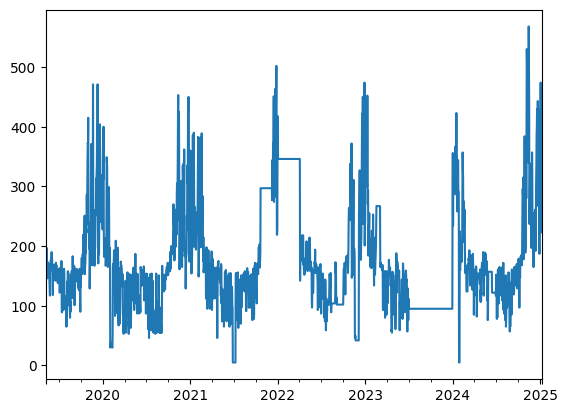

In [22]:
norm_aqi = new_data4['AQI']
norm_aqi.plot()

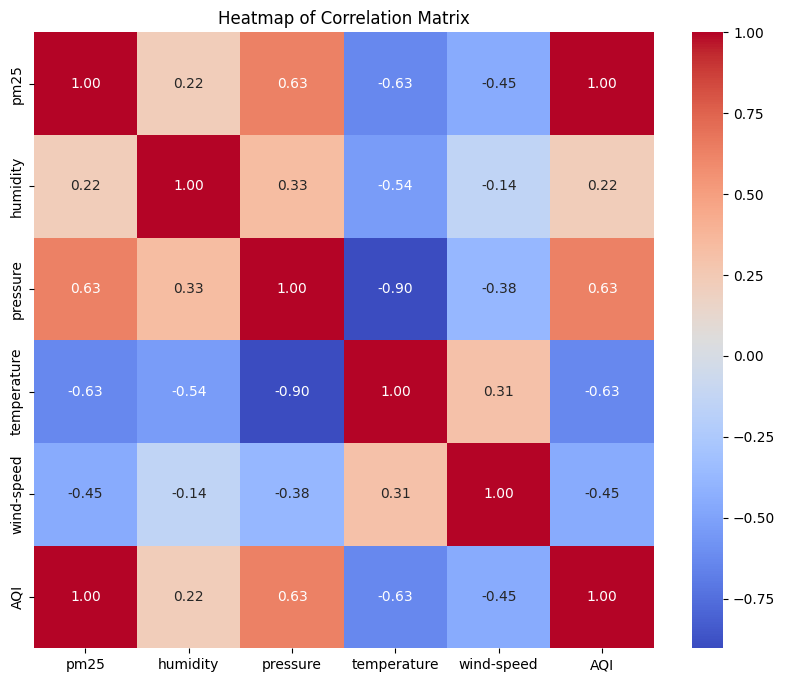

In [23]:
# Calculate the correlation matrix for numeric columns
corr = new_data4.corr(numeric_only=True)

# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix")
#file_name = "correlation_matrix.png"
#path = "/kaggle/working/data-after-combine"
#plt.savefig(path,file_name)
plt.show()

# 2. Machine Learning (without scaling)

# 2.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [24]:
new_data4.columns

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')

In [25]:
data = new_data4.copy()

In [26]:
data.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


In [27]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')
Index([], dtype='object')


In [28]:
X = data[['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1658, 5) (1658,) (415, 5) (415,)


In [29]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 2.2. ML Model

In [30]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [31]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

In [32]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")


Detailed Model Performance Summary:
--------------------------------------------------

KNN Results:
R² score (train): 0.9998
R² score (test): 0.9990
RMSE (train): 1.2491
RMSE (test): 3.0459
MAE (train): 0.7515
MAE (test): 1.2976
MSE (train): 1.5603
MSE (test): 9.2777

RANDOM_FOREST Results:
R² score (train): 1.0000
R² score (test): 0.9990
RMSE (train): 0.3701
RMSE (test): 3.0098
MAE (train): 0.0757
MAE (test): 0.3631
MSE (train): 0.1370
MSE (test): 9.0590

XGBOOST Results:
R² score (train): 1.0000
R² score (test): 0.9982
RMSE (train): 0.1387
RMSE (test): 4.0416
MAE (train): 0.0774
MAE (test): 0.8002
MSE (train): 0.0192
MSE (test): 16.3346

SVR Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0468
RMSE (test): 0.0481
MAE (train): 0.0413
MAE (test): 0.0425
MSE (train): 0.0022
MSE (test): 0.0023

NEURAL_NETWORK Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0681
RMSE (test): 0.0699
MAE (train): 0.0486
MAE (test): 0.0512
MSE (train): 0.

# 3. Machine Learning (with scaling)

# 3.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [33]:
new_data4.columns

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')

In [34]:
data = new_data4.copy()

In [35]:
data.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


In [36]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')
Index([], dtype='object')


In [37]:
X = data[['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1658, 5) (1658,) (415, 5) (415,)


In [38]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[ 
            ('scaler', StandardScaler())
        ]), ['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed'])  
    ])
    
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 3.2. ML Model

In [39]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [40]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")


Detailed Model Performance Summary:
--------------------------------------------------

KNN Results:
R² score (train): 0.9938
R² score (test): 0.9812
RMSE (train): 6.9841
RMSE (test): 12.9331
MAE (train): 4.6366
MAE (test): 8.2217
MSE (train): 48.7776
MSE (test): 167.2651

RANDOM_FOREST Results:
R² score (train): 1.0000
R² score (test): 0.9990
RMSE (train): 0.3729
RMSE (test): 2.9917
MAE (train): 0.0746
MAE (test): 0.3349
MSE (train): 0.1391
MSE (test): 8.9505

XGBOOST Results:
R² score (train): 1.0000
R² score (test): 0.9982
RMSE (train): 0.1387
RMSE (test): 4.0416
MAE (train): 0.0774
MAE (test): 0.8002
MSE (train): 0.0192
MSE (test): 16.3346

SVR Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0471
RMSE (test): 0.0497
MAE (train): 0.0388
MAE (test): 0.0413
MSE (train): 0.0022
MSE (test): 0.0025

NEURAL_NETWORK Results:
R² score (train): 0.9992
R² score (test): 0.9988
RMSE (train): 2.4744
RMSE (test): 3.2422
MAE (train): 0.8722
MAE (test): 1.0315
MSE (train)

# 4 - Deep Learning Model(Without Scaling)

# 4.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [42]:
aqi_normal = new_data4.copy()

In [43]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data.to_numpy()
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [44]:
WINDOW_SIZE = 6
NUM_FEATURES = 5
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    aqi_normal, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [45]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (1652, 6, 5) (1652,)
Validation shapes: (201, 6, 5) (201,)
Test shapes: (202, 6, 5) (202,)


#  4.2. DL Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Bi-LSTM

In [47]:
lstm_model = Sequential()
lstm_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
lstm_model.add(BatchNormalization())
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 6, 128)              │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,829 (311.83 KB)

 Trainable params: 79,755 (311.54 KB)

 Non-trainable params: 74 (296.00 B)

In [48]:
cp1 = ModelCheckpoint('/kaggle/working/lstm_model1.keras', save_best_only=True)

lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [49]:
lstm_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp1])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 37799.0508 - mean_absolute_error: 172.8256 - val_loss: 34052.4531 - val_mean_absolute_error: 166.5942
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 36489.7305 - mean_absolute_error: 171.0544 - val_loss: 33134.4297 - val_mean_absolute_error: 164.0501
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 35342.7969 - mean_absolute_error: 167.8907 - val_loss: 29991.4355 - val_mean_absolute_error: 155.3861
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 33171.9297 - mean_absolute_error: 164.0320 - val_loss: 23272.7637 - val_mean_absolute_error: 132.6112
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31764.5059 - mean_absolute_error: 160.4122 - val_loss: 16733.0508 - val_mean_absolute_error: 106.9910
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 26793.9434 - mean_absolute_error: 148.7501 - val_loss: 12921.9414 - val_mean_absolute_error: 92.5332
Epoch 7/100
52/52 ━━━━━━━━━━━

In [50]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/lstm_model1.keras')

In [51]:
# Evaluate the model on the train data
train_result = model1.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 21.8348
Mean Squared Error (MSE): 1205.0382
Root Mean Squared Error (RMSE): 34.7137
R-squared (Accuracy): 0.8492


In [52]:
# Evaluate the model on the validation data
val_result = model1.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 21.1958
Mean Squared Error (MSE): 1638.8931
Root Mean Squared Error (RMSE): 40.4832
R-squared (Accuracy): 0.7054


In [53]:
# Evaluate the model on the test data
test_result = model1.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 37.1303
Mean Squared Error (MSE): 3027.0045
Root Mean Squared Error (RMSE): 55.0182
R-squared (Accuracy): 0.7243


In [54]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,156.713791,172.0
1,161.892563,173.0
2,151.852295,163.0
3,143.418701,154.0
4,156.044662,171.0
...,...,...
1647,96.881287,95.0
1648,96.881287,95.0
1649,96.881287,95.0
1650,96.881287,95.0


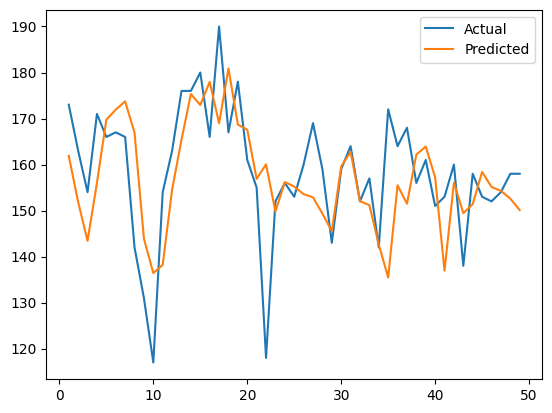

In [55]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [56]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,96.881287,95.0
1,96.881287,95.0
2,96.881287,95.0
3,96.881287,95.0
4,96.881287,95.0
...,...,...
196,159.703384,157.0
197,159.703384,157.0
198,159.703384,157.0
199,159.703384,122.0


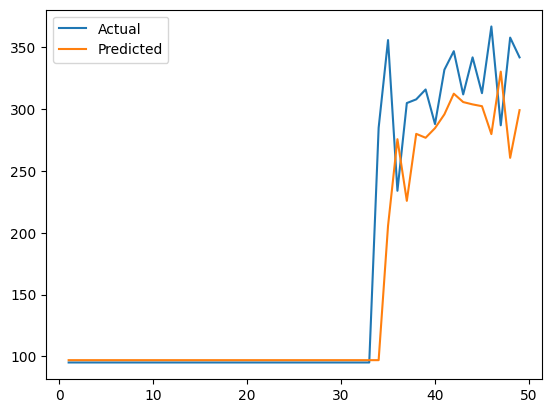

In [57]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [58]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,131.338226,122.0
1,131.338226,122.0
2,131.338226,122.0
3,131.338226,122.0
4,131.338226,122.0
...,...,...
197,286.425781,294.0
198,274.505341,267.0
199,265.014618,223.0
200,249.887207,252.0


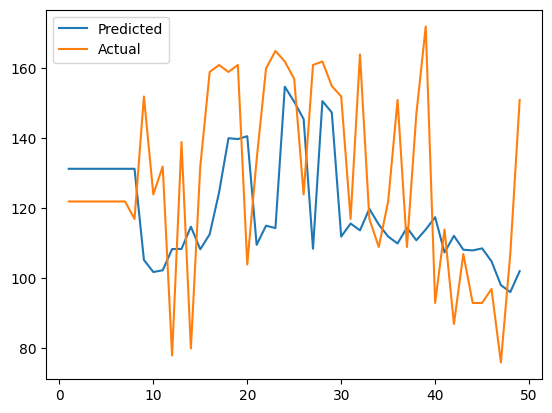

In [59]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

GRU

In [60]:
gru_model = Sequential()
gru_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
gru_model.add(BatchNormalization())
gru_model.add(Bidirectional(GRU(64, return_sequences=True)))
gru_model.add(Dropout(0.3))
gru_model.add(Bidirectional(GRU(32)))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(BatchNormalization())
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(1, activation='linear'))

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 6, 128)              │          27,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,141 (238.83 KB)

 Trainable params: 61,067 (238.54 KB)

 Non-trainable params: 74 (296.00 B)

In [61]:
cp2 = ModelCheckpoint('/kaggle/working/gru_model1.keras', save_best_only=True)

gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [62]:
gru_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp2])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 36991.7031 - mean_absolute_error: 171.2272 - val_loss: 33519.1094 - val_mean_absolute_error: 164.9751
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 36130.1680 - mean_absolute_error: 169.9077 - val_loss: 31035.2070 - val_mean_absolute_error: 157.6277
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 33727.8828 - mean_absolute_error: 165.1092 - val_loss: 27035.5898 - val_mean_absolute_error: 145.2910
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 33370.7539 - mean_absolute_error: 164.2609 - val_loss: 21958.4531 - val_mean_absolute_error: 127.5993
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 31206.1543 - mean_absolute_error: 158.9588 - val_loss: 18066.9395 - val_mean_absolute_error: 112.1950
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 30761.7891 - mean_absolute_error: 157.5142 - val_loss: 15273.7910 - val_mean_absolute_error: 101.7342
Epoch 7/100
52/52 ━━━━━━━━━━

In [63]:
from tensorflow.keras.models import load_model
model2 = load_model('/kaggle/working/gru_model1.keras')

In [64]:
# Evaluate the model on the train data
train_result = model2.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 23.1097
Mean Squared Error (MSE): 1313.6853
Root Mean Squared Error (RMSE): 36.2448
R-squared (Accuracy): 0.8356


In [65]:
# Evaluate the model on the validation data
val_result = model2.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 21.6571
Mean Squared Error (MSE): 1620.7051
Root Mean Squared Error (RMSE): 40.2580
R-squared (Accuracy): 0.7087


In [66]:
# Evaluate the model on the test data
test_result = model2.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 34.1830
Mean Squared Error (MSE): 2547.8751
Root Mean Squared Error (RMSE): 50.4765
R-squared (Accuracy): 0.7680


In [67]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,153.685303,172.0
1,162.655777,173.0
2,154.860565,163.0
3,147.865189,154.0
4,154.494766,171.0
...,...,...
1647,92.949043,95.0
1648,92.949043,95.0
1649,92.949043,95.0
1650,92.949043,95.0


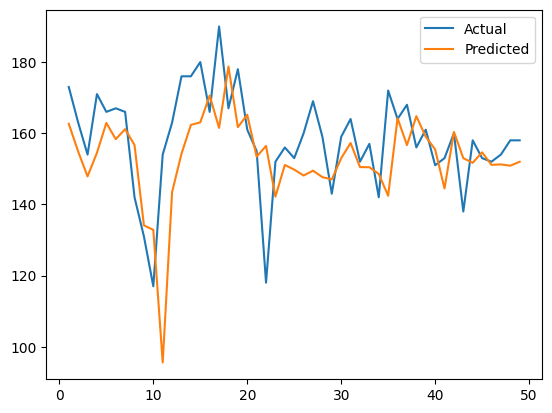

In [68]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [69]:
val_predictions = model2.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,92.949043,95.0
1,92.949043,95.0
2,92.949043,95.0
3,92.949043,95.0
4,92.949043,95.0
...,...,...
196,154.977142,157.0
197,154.977142,157.0
198,154.977142,157.0
199,154.977142,122.0


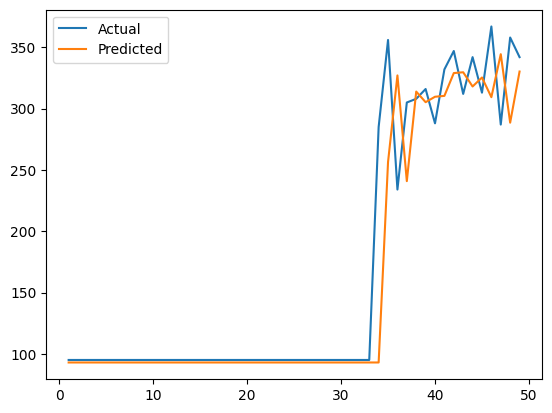

In [70]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [71]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,126.548454,122.0
1,126.548454,122.0
2,126.548454,122.0
3,126.548454,122.0
4,126.548454,122.0
...,...,...
197,308.718628,294.0
198,300.866119,267.0
199,281.128296,223.0
200,258.348572,252.0


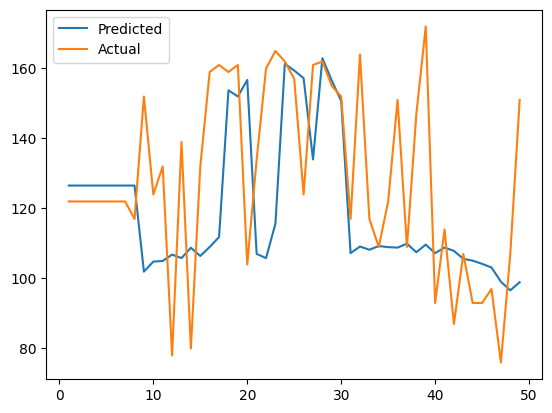

In [72]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

RNN

In [73]:
rnn_model = Sequential()
rnn_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
rnn_model.add(BatchNormalization())
rnn_model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
rnn_model.add(Dropout(0.3))
rnn_model.add(Bidirectional(SimpleRNN(32)))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(16, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))

rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_4                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 6, 128)              │           8,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,037 (86.08 KB)

 Trainable params: 21,963 (85.79 KB)

 Non-trainable params: 74 (296.00 B)

In [74]:
cp3 = ModelCheckpoint('/kaggle/working/rnn_model1.keras', save_best_only=True)

rnn_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [75]:
rnn_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp3])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 37144.6836 - mean_absolute_error: 171.8331 - val_loss: 34424.2812 - val_mean_absolute_error: 167.6684
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37379.5625 - mean_absolute_error: 172.3680 - val_loss: 33457.8867 - val_mean_absolute_error: 164.8308
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36251.9297 - mean_absolute_error: 169.4457 - val_loss: 32085.2246 - val_mean_absolute_error: 160.9685
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36587.6797 - mean_absolute_error: 171.0012 - val_loss: 30899.7559 - val_mean_absolute_error: 159.0149
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34582.3672 - mean_absolute_error: 167.0296 - val_loss: 30151.9902 - val_mean_absolute_error: 159.4278
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32326.8652 - mean_absolute_error: 161.5660 - val_loss: 26484.6367 - val_mean_absolute_error: 149.4234
Epoch 7/100
52/52 ━━━━━━━━━━━━━

In [76]:
from tensorflow.keras.models import load_model
model3 = load_model('/kaggle/working/rnn_model1.keras')

In [77]:
# Evaluate the model on the train data
train_result = model3.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 24.6170
Mean Squared Error (MSE): 1266.8754
Root Mean Squared Error (RMSE): 35.5932
R-squared (Accuracy): 0.8414


In [78]:
# Evaluate the model on the validation data
val_result = model3.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 26.2887
Mean Squared Error (MSE): 1707.7838
Root Mean Squared Error (RMSE): 41.3253
R-squared (Accuracy): 0.6930


In [79]:
# Evaluate the model on the test data
test_result = model3.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 34.7036
Mean Squared Error (MSE): 2817.9990
Root Mean Squared Error (RMSE): 53.0848
R-squared (Accuracy): 0.7434


In [80]:
train_predictions = model3.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,153.435699,172.0
1,163.824615,173.0
2,142.458511,163.0
3,138.408966,154.0
4,140.825897,171.0
...,...,...
1647,110.872307,95.0
1648,110.872307,95.0
1649,110.872307,95.0
1650,110.872307,95.0


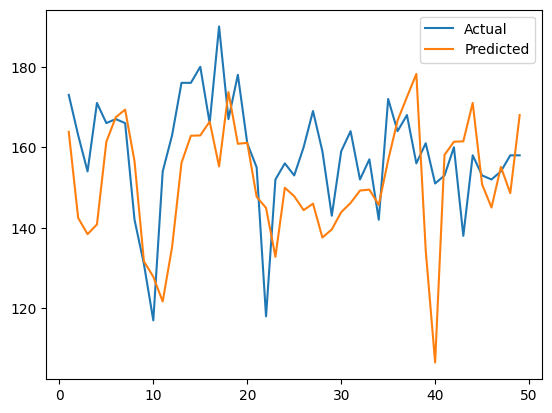

In [81]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [82]:
val_predictions = model3.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,110.872307,95.0
1,110.872307,95.0
2,110.872307,95.0
3,110.872307,95.0
4,110.872307,95.0
...,...,...
196,139.843597,157.0
197,139.843597,157.0
198,139.843597,157.0
199,139.843597,122.0


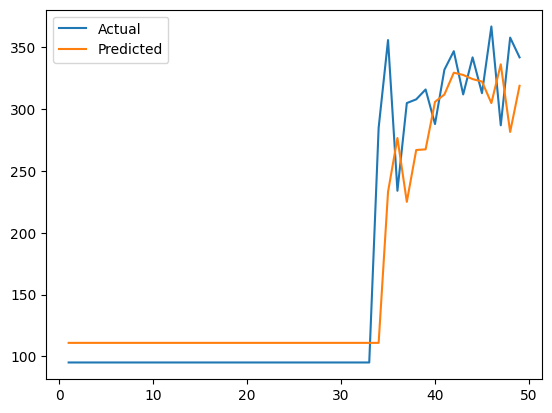

In [83]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [84]:
test_predictions = model3.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,122.949524,122.0
1,122.949524,122.0
2,122.949524,122.0
3,122.949524,122.0
4,122.949524,122.0
...,...,...
197,307.140320,294.0
198,285.683502,267.0
199,279.120422,223.0
200,253.947937,252.0


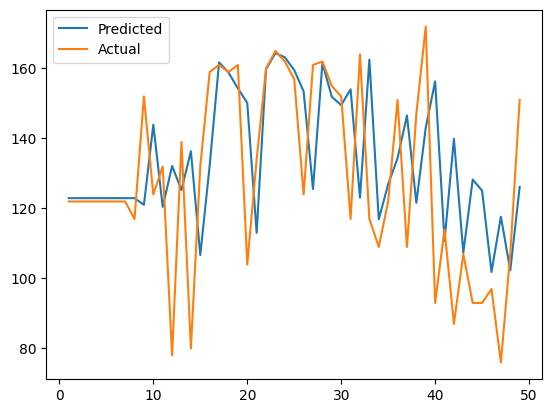

In [85]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

CNN-GRU(Bi)

In [86]:
cnn_gru_model = Sequential()
cnn_gru_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
cnn_gru_model.add(BatchNormalization())
cnn_gru_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model.add(Dropout(0.3))
cnn_gru_model.add(Bidirectional(GRU(32, return_sequences=True)))
cnn_gru_model.add(Dropout(0.3))
cnn_gru_model.add(Bidirectional(GRU(16)))
cnn_gru_model.add(Dense(32, activation='relu'))
cnn_gru_model.add(BatchNormalization())
cnn_gru_model.add(Dense(16, activation='relu'))
cnn_gru_model.add(Dense(1, activation='linear'))

cnn_gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_6                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 6, 128)              │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 6, 64)               │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 32)                  │           7,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,125 (215.33 KB)

 Trainable params: 55,051 (215.04 KB)

 Non-trainable params: 74 (296.00 B)

In [87]:
cp4 = ModelCheckpoint('/kaggle/working/cnn_gru_model1.keras', save_best_only=True)

cnn_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [88]:
cnn_gru_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp4])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 37780.1914 - mean_absolute_error: 172.1185 - val_loss: 34230.5469 - val_mean_absolute_error: 167.1454
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 38805.0508 - mean_absolute_error: 175.5552 - val_loss: 34513.3711 - val_mean_absolute_error: 168.0021
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 35894.2891 - mean_absolute_error: 169.4344 - val_loss: 32355.4629 - val_mean_absolute_error: 163.2995
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 36727.8047 - mean_absolute_error: 172.1960 - val_loss: 27437.4531 - val_mean_absolute_error: 148.3435
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 31711.1621 - mean_absolute_error: 161.1941 - val_loss: 26555.6289 - val_mean_absolute_error: 148.3916
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30952.4238 - mean_absolute_error: 159.5774 - val_loss: 20785.9219 - val_mean_absolute_error: 125.5521
Epoch 7/100
52/52 ━━━━━━━━━━

In [89]:
from tensorflow.keras.models import load_model
model4 = load_model('/kaggle/working/cnn_gru_model1.keras')

In [90]:
# Evaluate the model on the train data
train_result = model4.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 22.6415
Mean Squared Error (MSE): 1211.8388
Root Mean Squared Error (RMSE): 34.8115
R-squared (Accuracy): 0.8483


In [91]:
# Evaluate the model on the validation data
val_result = model4.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 22.0579
Mean Squared Error (MSE): 1627.4875
Root Mean Squared Error (RMSE): 40.3421
R-squared (Accuracy): 0.7074


In [92]:
# Evaluate the model on the test data
test_result = model4.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 34.6306
Mean Squared Error (MSE): 2697.4584
Root Mean Squared Error (RMSE): 51.9371
R-squared (Accuracy): 0.7543


In [93]:
train_predictions = model4.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,152.008041,172.0
1,159.903687,173.0
2,141.606781,163.0
3,138.940674,154.0
4,154.711487,171.0
...,...,...
1647,101.555550,95.0
1648,101.555550,95.0
1649,101.555550,95.0
1650,101.555550,95.0


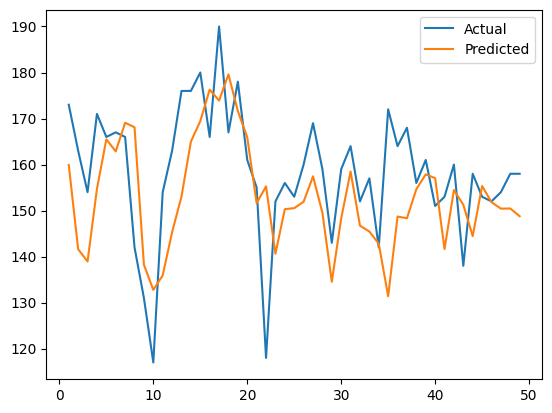

In [94]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [95]:
val_predictions = model4.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,101.555550,95.0
1,101.555550,95.0
2,101.555550,95.0
3,101.555550,95.0
4,101.555550,95.0
...,...,...
196,155.722717,157.0
197,155.722717,157.0
198,155.722717,157.0
199,155.722717,122.0


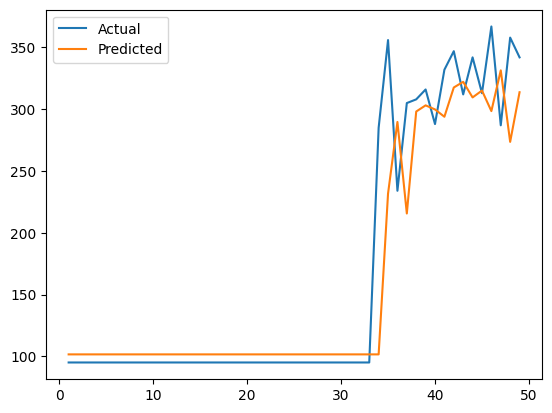

In [96]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [97]:
test_predictions = model4.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,128.353577,122.0
1,128.353577,122.0
2,128.353577,122.0
3,128.353577,122.0
4,128.353577,122.0
...,...,...
197,278.356873,294.0
198,277.480804,267.0
199,263.720215,223.0
200,246.914734,252.0


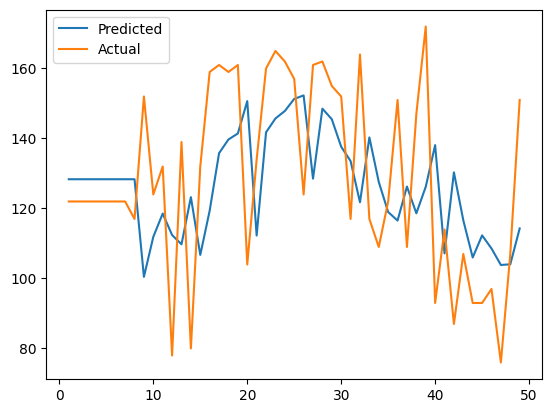

In [98]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

# 5 - Deep Learning Model(With Scaling)

# 5.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [99]:
aqi_normal = new_data4.copy()

In [100]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aqi_normal)

In [101]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [102]:
WINDOW_SIZE = 6
NUM_FEATURES = 5
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    scaled_data, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [103]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (1652, 6, 5) (1652,)
Validation shapes: (201, 6, 5) (201,)
Test shapes: (202, 6, 5) (202,)


#  5.2. DL Model

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Bi-LSTM

In [105]:
lstm_model_v = Sequential()
lstm_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
lstm_model_v.add(BatchNormalization())
lstm_model_v.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model_v.add(Dropout(0.3))
lstm_model_v.add(Bidirectional(LSTM(32)))
lstm_model_v.add(Dropout(0.3))
lstm_model_v.add(Dense(32, activation='relu'))
lstm_model_v.add(BatchNormalization())
lstm_model_v.add(Dense(16, activation='relu'))
lstm_model_v.add(Dense(1, activation='linear'))

lstm_model_v.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_8                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 6, 128)              │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,829 (311.83 KB)

 Trainable params: 79,755 (311.54 KB)

 Non-trainable params: 74 (296.00 B)

In [106]:
cp5 = ModelCheckpoint('/kaggle/working/lstm_model_v1.keras', save_best_only=True)

lstm_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [107]:
lstm_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp5])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.7205 - mean_absolute_error: 0.6379 - val_loss: 0.5789 - val_mean_absolute_error: 0.5186
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4578 - mean_absolute_error: 0.4916 - val_loss: 0.5465 - val_mean_absolute_error: 0.4865
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3228 - mean_absolute_error: 0.4197 - val_loss: 0.5000 - val_mean_absolute_error: 0.4690
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3118 - mean_absolute_error: 0.4115 - val_loss: 0.4490 - val_mean_absolute_error: 0.4280
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2804 - mean_absolute_error: 0.3898 - val_loss: 0.3800 - val_mean_absolute_error: 0.3819
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2670 - mean_absolute_error: 0.3789 - val_loss: 0.3274 - val_mean_absolute_error: 0.3487
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2829 - mean_absolute_error: 0.3867 - v

In [108]:
from tensorflow.keras.models import load_model
model5 = load_model('/kaggle/working/lstm_model_v1.keras')

In [109]:
# Evaluate the model on the train data
train_result = model5.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2413
Mean Squared Error (MSE): 0.1451
Root Mean Squared Error (RMSE): 0.3809
R-squared (Accuracy): 0.8530


In [110]:
# Evaluate the model on the validation data
val_result = model5.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2345
Mean Squared Error (MSE): 0.2151
Root Mean Squared Error (RMSE): 0.4638
R-squared (Accuracy): 0.6870


In [111]:
# Evaluate the model on the test data
test_result = model5.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.4304
Mean Squared Error (MSE): 0.4374
Root Mean Squared Error (RMSE): 0.6613
R-squared (Accuracy): 0.6776


In [112]:
train_predictions = model5.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,-0.215036,-0.051393
1,-0.200067,-0.040277
2,-0.182531,-0.151439
3,-0.260975,-0.251485
4,-0.201052,-0.062509
...,...,...
1647,-0.892573,-0.907341
1648,-0.892573,-0.907341
1649,-0.892573,-0.907341
1650,-0.892573,-0.907341


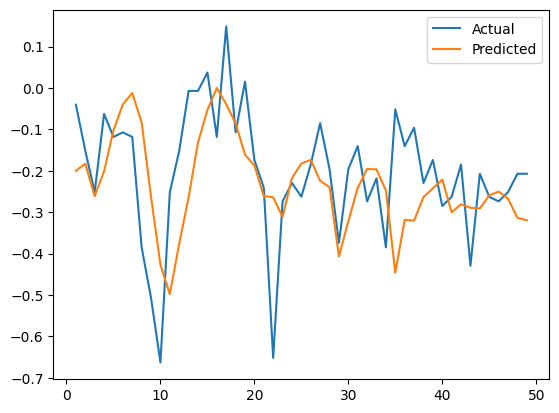

In [113]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [114]:
val_predictions = model5.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.892573,-0.907341
1,-0.892573,-0.907341
2,-0.892573,-0.907341
3,-0.892573,-0.907341
4,-0.892573,-0.907341
...,...,...
196,-0.219974,-0.218136
197,-0.219974,-0.218136
198,-0.219974,-0.218136
199,-0.219974,-0.607204


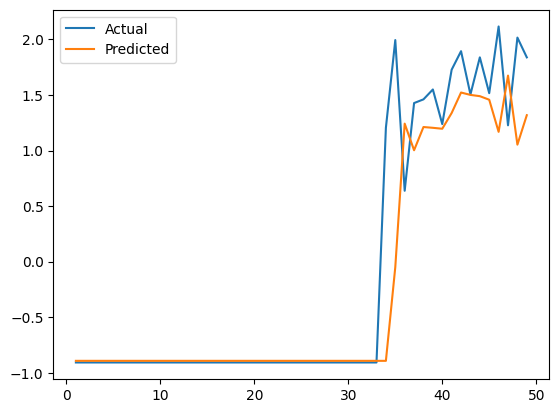

In [115]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [116]:
test_predictions = model5.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.547482,-0.607204
1,-0.547482,-0.607204
2,-0.547482,-0.607204
3,-0.547482,-0.607204
4,-0.547482,-0.607204
...,...,...
197,1.502002,1.304785
198,0.907927,1.004647
199,0.849159,0.515534
200,0.942723,0.837904


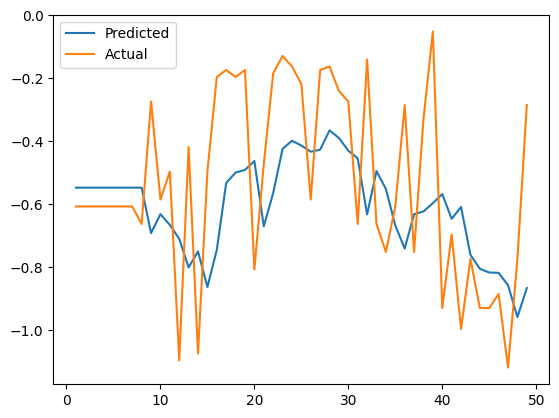

In [117]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

GRU

In [118]:
gru_model_v = Sequential()
gru_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
gru_model_v.add(BatchNormalization())
gru_model_v.add(Bidirectional(GRU(64, return_sequences=True)))
gru_model_v.add(Dropout(0.3))
gru_model_v.add(Bidirectional(GRU(32)))
gru_model_v.add(Dropout(0.3))
gru_model_v.add(Dense(32, activation='relu'))
gru_model_v.add(BatchNormalization())
gru_model_v.add(Dense(16, activation='relu'))
gru_model_v.add(Dense(1, activation='linear'))

gru_model_v.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_10               │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 6, 128)              │          27,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,141 (238.83 KB)

 Trainable params: 61,067 (238.54 KB)

 Non-trainable params: 74 (296.00 B)

In [119]:
cp6 = ModelCheckpoint('/kaggle/working/gru_model_v1.keras', save_best_only=True)

gru_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [120]:
gru_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp6])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.0866 - mean_absolute_error: 0.7733 - val_loss: 0.5035 - val_mean_absolute_error: 0.5264
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3705 - mean_absolute_error: 0.4689 - val_loss: 0.4231 - val_mean_absolute_error: 0.4327
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3131 - mean_absolute_error: 0.4188 - val_loss: 0.3597 - val_mean_absolute_error: 0.3726
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2720 - mean_absolute_error: 0.3887 - val_loss: 0.3050 - val_mean_absolute_error: 0.3226
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2960 - mean_absolute_error: 0.4006 - val_loss: 0.2730 - val_mean_absolute_error: 0.2979
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2529 - mean_absolute_error: 0.3671 - val_loss: 0.2623 - val_mean_absolute_error: 0.2838
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2288 - mean_absolute_error: 0.3534 - v

In [121]:
from tensorflow.keras.models import load_model
model6 = load_model('/kaggle/working/gru_model_v1.keras')

In [122]:
# Evaluate the model on the train data
train_result = model6.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2525
Mean Squared Error (MSE): 0.1519
Root Mean Squared Error (RMSE): 0.3897
R-squared (Accuracy): 0.8462


In [123]:
# Evaluate the model on the validation data
val_result = model6.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2548
Mean Squared Error (MSE): 0.2105
Root Mean Squared Error (RMSE): 0.4588
R-squared (Accuracy): 0.6938


In [124]:
# Evaluate the model on the test data
test_result = model6.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.3902
Mean Squared Error (MSE): 0.3529
Root Mean Squared Error (RMSE): 0.5941
R-squared (Accuracy): 0.7399


In [125]:
train_predictions = model6.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,-0.253332,-0.051393
1,-0.233797,-0.040277
2,-0.357929,-0.151439
3,-0.437372,-0.251485
4,-0.291557,-0.062509
...,...,...
1647,-0.830588,-0.907341
1648,-0.830588,-0.907341
1649,-0.830588,-0.907341
1650,-0.830588,-0.907341


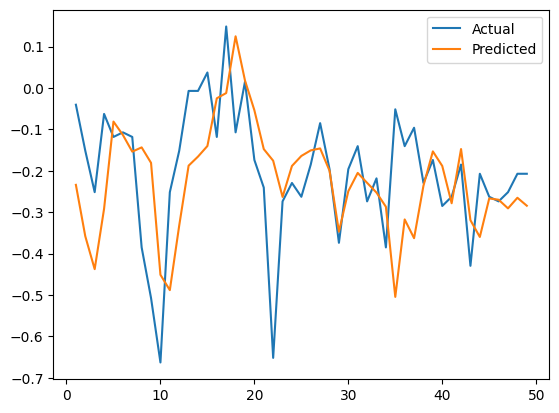

In [126]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [127]:
val_predictions = model6.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Train Predictions,Actuals
0,-0.830588,-0.907341
1,-0.830588,-0.907341
2,-0.830588,-0.907341
3,-0.830588,-0.907341
4,-0.830588,-0.907341
...,...,...
196,-0.231827,-0.218136
197,-0.231827,-0.218136
198,-0.231827,-0.218136
199,-0.231827,-0.607204


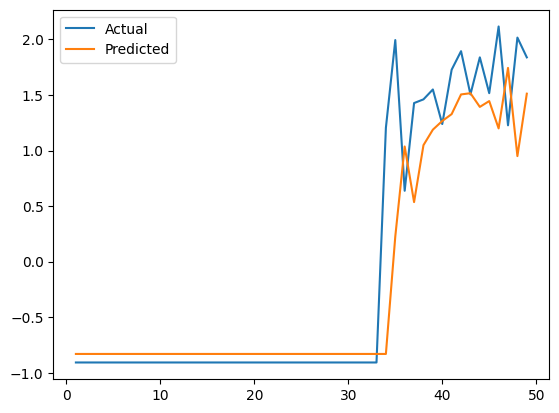

In [128]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [129]:
test_predictions = model6.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.556768,-0.607204
1,-0.556768,-0.607204
2,-0.556768,-0.607204
3,-0.556768,-0.607204
4,-0.556768,-0.607204
...,...,...
197,1.269508,1.304785
198,1.095674,1.004647
199,0.956229,0.515534
200,0.869311,0.837904


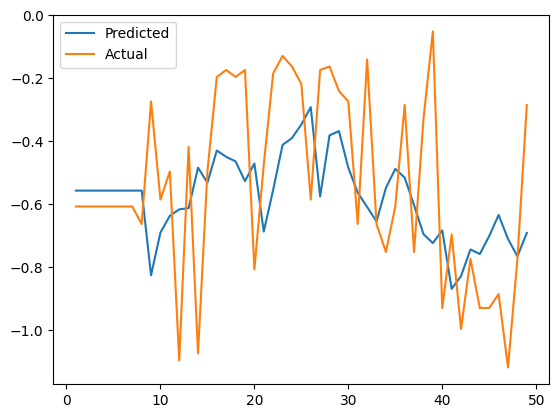

In [130]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

RNN

In [131]:
rnn_model_v = Sequential()
rnn_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
rnn_model_v.add(BatchNormalization())
rnn_model_v.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
rnn_model_v.add(Dropout(0.3))
rnn_model_v.add(Bidirectional(SimpleRNN(32)))
rnn_model_v.add(Dropout(0.3))
rnn_model_v.add(Dense(32, activation='relu'))
rnn_model_v.add(BatchNormalization())
rnn_model_v.add(Dense(16, activation='relu'))
rnn_model_v.add(Dense(1, activation='linear'))

rnn_model_v.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_12               │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 6, 128)              │           8,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,037 (86.08 KB)

 Trainable params: 21,963 (85.79 KB)

 Non-trainable params: 74 (296.00 B)

In [132]:
cp7 = ModelCheckpoint('/kaggle/working/rnn_model_v1.keras', save_best_only=True)

rnn_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [133]:
rnn_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp7])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 1.2016 - mean_absolute_error: 0.8539 - val_loss: 0.5068 - val_mean_absolute_error: 0.4888
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6049 - mean_absolute_error: 0.6007 - val_loss: 0.3296 - val_mean_absolute_error: 0.3705
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5062 - mean_absolute_error: 0.5490 - val_loss: 0.3106 - val_mean_absolute_error: 0.3502
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3840 - mean_absolute_error: 0.4648 - val_loss: 0.2945 - val_mean_absolute_error: 0.3367
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4229 - mean_absolute_error: 0.4778 - val_loss: 0.2825 - val_mean_absolute_error: 0.3273
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3544 - mean_absolute_error: 0.4543 - val_loss: 0.2710 - val_mean_absolute_error: 0.3197
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3127 - mean_absolute_error: 0.4197 - val_lo

In [134]:
from tensorflow.keras.models import load_model
model7 = load_model('/kaggle/working/rnn_model_v1.keras')

In [135]:
# Evaluate the model on the train data
train_result = model7.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2318
Mean Squared Error (MSE): 0.1339
Root Mean Squared Error (RMSE): 0.3659
R-squared (Accuracy): 0.8644


In [136]:
# Evaluate the model on the validation data
val_result = model7.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2464
Mean Squared Error (MSE): 0.2159
Root Mean Squared Error (RMSE): 0.4646
R-squared (Accuracy): 0.6860


In [137]:
# Evaluate the model on the test data
test_result = model7.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.4344
Mean Squared Error (MSE): 0.4135
Root Mean Squared Error (RMSE): 0.6431
R-squared (Accuracy): 0.6952


In [138]:
train_predictions = model7.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,-0.301306,-0.051393
1,-0.184940,-0.040277
2,-0.261951,-0.151439
3,-0.404765,-0.251485
4,-0.272966,-0.062509
...,...,...
1647,-0.906747,-0.907341
1648,-0.906747,-0.907341
1649,-0.906747,-0.907341
1650,-0.906747,-0.907341


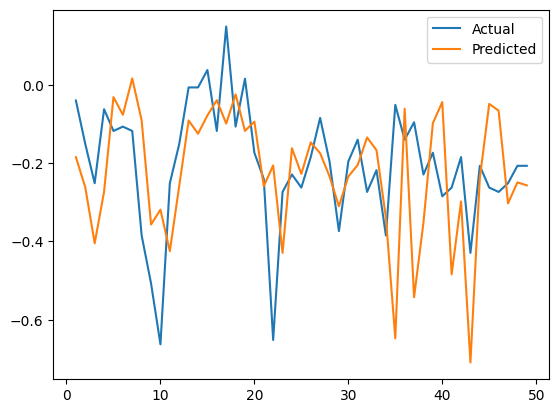

In [139]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [140]:
val_predictions = model7.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.906747,-0.907341
1,-0.906747,-0.907341
2,-0.906747,-0.907341
3,-0.906747,-0.907341
4,-0.906747,-0.907341
...,...,...
196,-0.223558,-0.218136
197,-0.223558,-0.218136
198,-0.223558,-0.218136
199,-0.223558,-0.607204


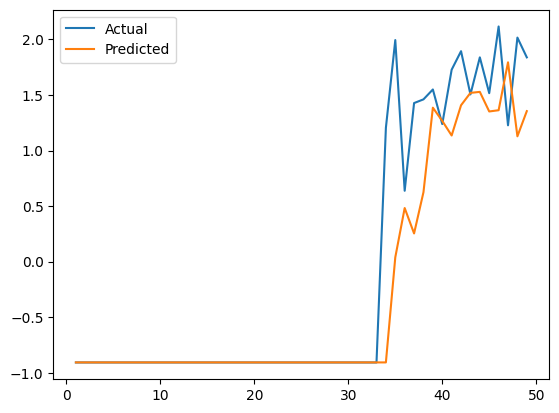

In [141]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [142]:
test_predictions = model7.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.497529,-0.607204
1,-0.497529,-0.607204
2,-0.497529,-0.607204
3,-0.497529,-0.607204
4,-0.497529,-0.607204
...,...,...
197,1.267729,1.304785
198,1.320222,1.004647
199,1.452486,0.515534
200,1.167152,0.837904


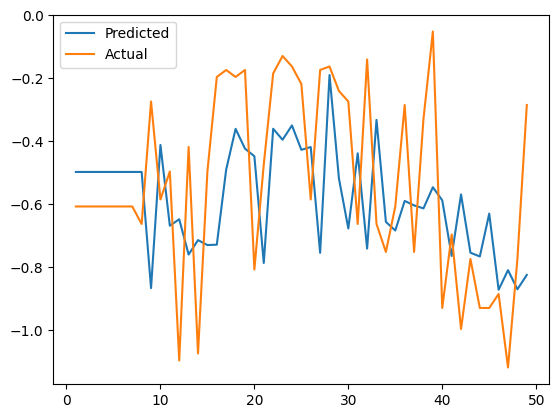

In [143]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

CNN-GRU(Bi)

In [144]:
cnn_gru_model_v = Sequential()
cnn_gru_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
cnn_gru_model_v.add(BatchNormalization())
cnn_gru_model_v.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model_v.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model_v.add(Dropout(0.3))
cnn_gru_model_v.add(Bidirectional(GRU(32, return_sequences=True)))
cnn_gru_model_v.add(Dropout(0.3))
cnn_gru_model_v.add(Bidirectional(GRU(16)))
cnn_gru_model_v.add(Dense(32, activation='relu'))
cnn_gru_model_v.add(BatchNormalization())
cnn_gru_model_v.add(Dense(16, activation='relu'))
cnn_gru_model_v.add(Dense(1, activation='linear'))

cnn_gru_model_v.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_14               │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 128)              │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 6, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 6, 64)               │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 32)                  │           7,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,125 (215.33 KB)

 Trainable params: 55,051 (215.04 KB)

 Non-trainable params: 74 (296.00 B)

In [145]:
cp8 = ModelCheckpoint('/kaggle/working/cnn_gru_model_v1.keras', save_best_only=True)

cnn_gru_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [146]:
cnn_gru_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp8])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.3066 - mean_absolute_error: 0.8684 - val_loss: 0.6078 - val_mean_absolute_error: 0.5496
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3364 - mean_absolute_error: 0.4401 - val_loss: 0.5712 - val_mean_absolute_error: 0.5403
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3061 - mean_absolute_error: 0.4064 - val_loss: 0.5395 - val_mean_absolute_error: 0.5134
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2824 - mean_absolute_error: 0.3835 - val_loss: 0.5062 - val_mean_absolute_error: 0.5097
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2509 - mean_absolute_error: 0.3693 - val_loss: 0.4723 - val_mean_absolute_error: 0.5031
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2371 - mean_absolute_error: 0.3398 - val_loss: 0.4057 - val_mean_absolute_error: 0.4644
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2690 - mean_absolute_error: 0.3722 - v

In [147]:
from tensorflow.keras.models import load_model
model8 = load_model('/kaggle/working/cnn_gru_model_v1.keras')

In [148]:
# Evaluate the model on the train data
train_result = model8.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2391
Mean Squared Error (MSE): 0.1382
Root Mean Squared Error (RMSE): 0.3717
R-squared (Accuracy): 0.8601


In [149]:
# Evaluate the model on the validation data
val_result = model8.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2474
Mean Squared Error (MSE): 0.2168
Root Mean Squared Error (RMSE): 0.4656
R-squared (Accuracy): 0.6847


In [150]:
# Evaluate the model on the test data
test_result = model8.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 0.4090
Mean Squared Error (MSE): 0.3803
Root Mean Squared Error (RMSE): 0.6167
R-squared (Accuracy): 0.7197


In [151]:
train_predictions = model8.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,-0.111083,-0.051393
1,-0.102536,-0.040277
2,-0.109118,-0.151439
3,-0.282063,-0.251485
4,-0.203657,-0.062509
...,...,...
1647,-0.844161,-0.907341
1648,-0.844161,-0.907341
1649,-0.844161,-0.907341
1650,-0.844161,-0.907341


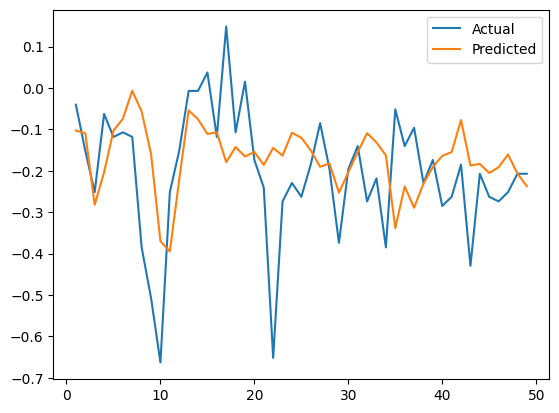

In [152]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [153]:
val_predictions = model8.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.844161,-0.907341
1,-0.844161,-0.907341
2,-0.844161,-0.907341
3,-0.844161,-0.907341
4,-0.844161,-0.907341
...,...,...
196,-0.190397,-0.218136
197,-0.190397,-0.218136
198,-0.190397,-0.218136
199,-0.190397,-0.607204


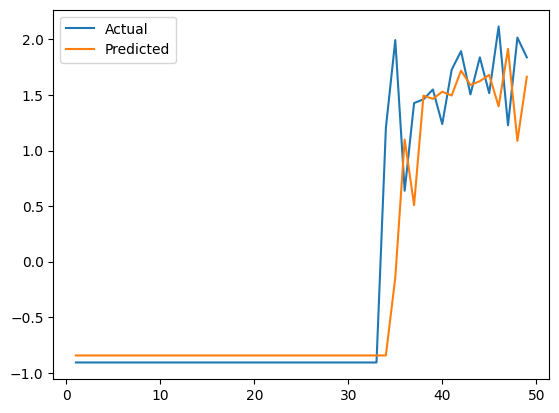

In [154]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [155]:
test_predictions = model8.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,-0.494132,-0.607204
1,-0.494132,-0.607204
2,-0.494132,-0.607204
3,-0.494132,-0.607204
4,-0.494132,-0.607204
...,...,...
197,1.283735,1.304785
198,1.400578,1.004647
199,1.050086,0.515534
200,0.743159,0.837904


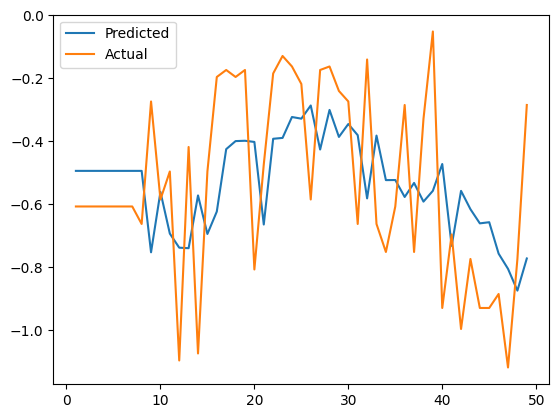

In [156]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()